### Import

In [137]:
import os
import torch
import sys
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.datasets import make_classification
from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import confusion_matrix

### Create Data

In [120]:
n_features = 100
n_classes = 10
noise = 0.0
X,y = make_classification(n_samples=1000,
                                      n_features=n_features,
                                      n_informative=n_features,
                                      n_redundant=0,
                                      n_repeated=0,
                                      n_classes=n_classes,
                                      n_clusters_per_class=1,
                                      weights=None,
                                      flip_y=noise,
                                      class_sep=2.0,
                                      hypercube=True,
                                      shift=0.0,
                                      shuffle=True,
                                      random_state=42)

### Split the data

In [121]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
x_val = np.array(x_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

### Convert to torch Tensor

In [122]:
train_inputs = Variable(torch.from_numpy(x_train))
train_labels = Variable(torch.from_numpy(y_train))
train_labels = train_labels.type(torch.LongTensor)

val_inputs = Variable(torch.from_numpy(x_val))
val_labels = Variable(torch.from_numpy(y_val))
val_labels = val_labels.type(torch.LongTensor)

#inputs = Variable(torch.from_numpy(x_train).cuda())
#labels = Variable(torch.from_numpy(y_train).cuda())

### Create Deep Belief Model

In [123]:
class DeepBeliefClassifier(nn.Module):
    def __init__(self):
        super(DeepBeliefClassifier,self).__init__()
        hidden_1 = 50
        hidden_2 = 25
        self.fc1 = nn.Linear(n_features,hidden_1)
        self.fc2 = nn.Linear(hidden_1,hidden_2)
        self.fc3 = nn.Linear(hidden_2,n_classes)
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        # flatten image input
        x = x.view(-1,100)
        x = F.relu(self.fc1(x))
        x = self.droput(x)
        x = F.relu(self.fc2(x))
        x = self.droput(x)
        x = self.fc3(x)
        return x

### Parameters

In [124]:
learningRate = 0.01 
n_epochs = 5000

### Instantiate Model

In [125]:
model = DeepBeliefClassifier()
print(model)

DeepBeliefClassifier(
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


### Optimizer parameters

In [126]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = learningRate)

### Start Training

In [127]:
valid_loss_min = np.Inf
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []
for epoch in range(n_epochs):

    #Training
    model.train()
    optimizer.zero_grad()
    train_output = model(train_inputs)
    train_loss = criterion(train_output,train_labels)
    train_loss.backward()
    optimizer.step()
    train_loss_history.append(train_loss.item())
    
    #Validation
    model.eval()
    val_output = model(val_inputs)
    val_loss = criterion(val_output,val_labels)
    val_loss_history.append(val_loss.item())

    #Compute accuracy
    _,train_pred = torch.max(train_output, 1)    
    train_accuracy = np.sum(train_pred.numpy() == train_labels.numpy()) / len(train_labels.numpy())
    train_accuracy_history.append(train_accuracy)

    _,val_pred = torch.max(val_output, 1)
    val_accuracy = np.sum(val_pred.numpy() == val_labels.numpy()) / len(val_labels.numpy())
    val_accuracy_history.append(val_accuracy)
    
    #Verbose
    if (epoch % 100 == 0):
        print('Epoch: {}, Training Loss: {:.6f}, Validation Loss: {:.6f}'.format(epoch, train_loss,val_loss))
    
#Save the model
torch.save(model.state_dict(), 'model.pt')

Epoch: 0, Training Loss: 2.409245, Validation Loss: 2.386229
Epoch: 100, Training Loss: 1.897477, Validation Loss: 1.964517
Epoch: 200, Training Loss: 1.281052, Validation Loss: 1.364515
Epoch: 300, Training Loss: 0.859699, Validation Loss: 0.874294
Epoch: 400, Training Loss: 0.593332, Validation Loss: 0.621143
Epoch: 500, Training Loss: 0.520090, Validation Loss: 0.488084
Epoch: 600, Training Loss: 0.438472, Validation Loss: 0.412529
Epoch: 700, Training Loss: 0.348102, Validation Loss: 0.367245
Epoch: 800, Training Loss: 0.303273, Validation Loss: 0.336585
Epoch: 900, Training Loss: 0.267424, Validation Loss: 0.316814
Epoch: 1000, Training Loss: 0.214775, Validation Loss: 0.307017
Epoch: 1100, Training Loss: 0.185946, Validation Loss: 0.296427
Epoch: 1200, Training Loss: 0.172230, Validation Loss: 0.289010
Epoch: 1300, Training Loss: 0.156077, Validation Loss: 0.284914
Epoch: 1400, Training Loss: 0.151003, Validation Loss: 0.280174
Epoch: 1500, Training Loss: 0.141107, Validation Los

### Plot Loss and accuracy

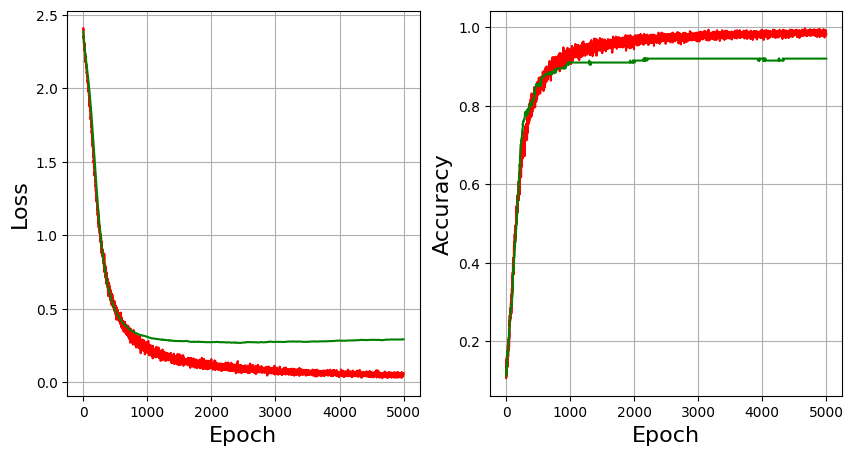

In [128]:
train_loss_history = np.array(train_loss_history)
val_loss_history = np.array(val_loss_history)
train_accuracy_history = np.array(train_accuracy_history)
val_accuracy_history = np.array(val_accuracy_history)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss_history,'r')
plt.plot(val_loss_history,'g')
plt.grid();
plt.xlabel('Epoch',fontsize=16);
plt.ylabel('Loss',fontsize=16);

plt.subplot(1,2,2)
plt.plot(train_accuracy_history,'r')
plt.plot(val_accuracy_history,'g')
plt.grid();
plt.xlabel('Epoch',fontsize=16);
plt.ylabel('Accuracy',fontsize=16);

### Get Parameters and compare with actual coefficients

In [136]:
for name,param in model.named_parameters():
    if 'weight' in name:
        w = param[0].detach().numpy()
        print(name)
        print(w)
    if 'bias' in name:
        b = param[0].detach().numpy()        
        print(name)
        print(b)

# plt.figure(figsize=(6,6))        
# plt.scatter(w,coef,c='r')
# plt.scatter(b,bias,c='g')
# plt.grid()

fc1.weight
[ 0.12287929  0.01472556  0.0372835  -0.11591526  0.01407655  0.06160849
  0.14240353  0.01804039  0.02666428  0.01556909 -0.04307513  0.03756383
 -0.09840313  0.08982477  0.10845381 -0.05621908 -0.03557326  0.11748412
  0.07212981 -0.02981414 -0.07104589 -0.03824827  0.05652351 -0.08279818
  0.00680107 -0.08748387 -0.08388255 -0.03699452 -0.07738719  0.07478554
  0.00797045  0.06070276 -0.05974406  0.07247845  0.13647056 -0.05326692
  0.11429812 -0.04997596  0.03618561 -0.06886851  0.04913453 -0.03048478
 -0.18909355  0.06426126  0.09083031  0.06129687 -0.15759438  0.10585822
  0.08608566 -0.00639066  0.07974134 -0.11264095  0.02599929  0.02772311
  0.06997925 -0.01139581  0.156229    0.01065915  0.02397126  0.03810648
 -0.00552722 -0.00476313 -0.01561931  0.06640478 -0.11668182  0.05929017
 -0.03180018  0.03916579 -0.04196375  0.06959588  0.10263963 -0.03430557
  0.10047375  0.17063144  0.04998539  0.07342946  0.02687424  0.05877333
  0.04559923 -0.02628351  0.07995869  0.

### Create Confusion Matrix

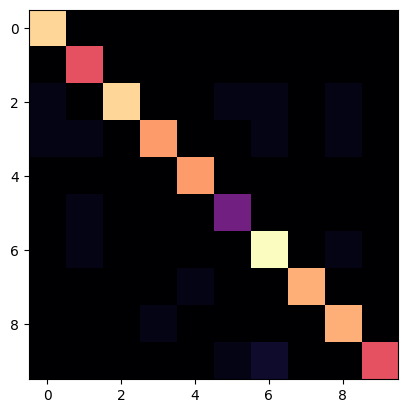

In [139]:
model.eval()
val_output = model(val_inputs)
_,val_pred = torch.max(val_output, 1)
val_pred = val_pred.numpy()
C = confusion_matrix(val_labels, val_pred)
plt.imshow(C,cmap='magma')